# Setting

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns# Setting

import json
from anytree.importer import JsonImporter
from anytree import PreOrderIter

In [2]:
from scipy import stats
from scipy.stats import ttest_rel,ttest_ind,mannwhitneyu,wilcoxon,normaltest,shapiro,sem, spearmanr

import statsmodels.api as sm
import pylab as py

In [3]:
# Set the style to remove top and right borders
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
# set the font size
plt.rcParams.update({'font.size': 11})
# remove legend edge
plt.rcParams['legend.frameon'] = False

In [4]:
home_dir = '/Users/dbao/My_Drive'+'/road_construction/data/2022_online/'
map_dir = 'active_map/'
# data_dir  = 'data/preprocessed'
# out_dir = home_dir + 'figures/cogsci_2022/'
out_dir2 = home_dir + 'stat_model/'
R_out_dir = home_dir + 'R_analysis_data/'

In [5]:
data_puzzle_level = pd.read_csv(R_out_dir +  'data.csv') # first column is subject

puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID","condition"])

puzzleID_order_data['sqrt_nos'] = np.sqrt(puzzleID_order_data.nos)
puzzleID_order_data['log_RT1'] = np.log(puzzleID_order_data.RT1)
puzzleID_order_data['mas'] = puzzleID_order_data.mas - 1

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index(drop=True)

In [6]:
data_choice_level = pd.read_csv(R_out_dir +  'choice_level/choicelevel_data.csv', index_col=0) # first column is index 

data_choice_level['sqrt_leftover'] = np.sqrt(data_choice_level.leftover)
data_choice_level['currNumCities'] = data_choice_level.currNumCities - 1 # starting from 0
data_choice_level['allMAS'] = data_choice_level.allMAS - 1
data_choice_level['currMas'] = data_choice_level.currMas - 1
data_choice_level["step"] = data_choice_level.currNumCities/data_choice_level.allMAS

sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index(drop=True) # 

with open(home_dir +'tree_data/undo_tree', 'r') as file:
    undo_tree = json.load(file)

In [7]:
def sigmoid(x):
    e = np.exp(1)
    y = 1/(1+e**(-x))
    return y


single_condition_data['sqrt_leftover'] = np.sqrt(single_condition_data.leftover)
single_condition_data['sqrt_numFullUndo'] = np.sqrt(single_condition_data.numFullUndo)
# single_condition_data['percentile_numFullUndo'] = single_condition_data.numFullUndo.rank(method='min')

In [8]:
# helper functions
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

# add p-value to figure
def text(p):
    if p == 0:
        axs.text((x1+x2)*.5, y+h,  r"$p = {:.1f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)
    elif p < 0.001:
        axs.text((x1+x2)*.5, y+h, r"$p = {0:s}$".format(as_si(p,1)), ha='center', va='bottom', color=col, fontsize = 8)
    elif p > 0.1:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.2f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)

    elif 0.01 < p < 0.1:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.3f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)
    else:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.4f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)

In [7]:
%load_ext rpy2.ipython
from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')
#lmerTest = importr('lmerTest')
mass = importr('MASS')
#optimx = importr('optimx')
#brms = importr('brms')
statmod = importr('statmod')
# bbmle = importr('bbmle') 

# undo RT

when undo RT is short, it is single undo; when it is longer, it is sequential undo.

In [8]:
def get_undoRT(index):
    RT = data_choice_level.loc[index,:]
    RT_sub = RT.groupby(['subjects'])['undoRT'].mean()/1000
    RT_sub_sem = sem(RT_sub, nan_policy='omit')
    return [RT_sub,RT_sub_sem]

index_singleUndo = data_choice_level.index[(data_choice_level['firstUndo'] == 1)&(data_choice_level['lastUndo'] == 1)]
RT_singleUndo = get_undoRT(index_singleUndo)

index_firstUndo = data_choice_level.index[(data_choice_level['firstUndo'] == 1) &(data_choice_level['lastUndo'] != 1)]
RT_firstUndo = get_undoRT(index_firstUndo)

index_laterUndo = data_choice_level.index[(data_choice_level['firstUndo'] != 1) & (data_choice_level['undo'] == 1)]
RT_laterUndo = get_undoRT(index_laterUndo)

### bar plot

<IPython.core.display.Javascript object>


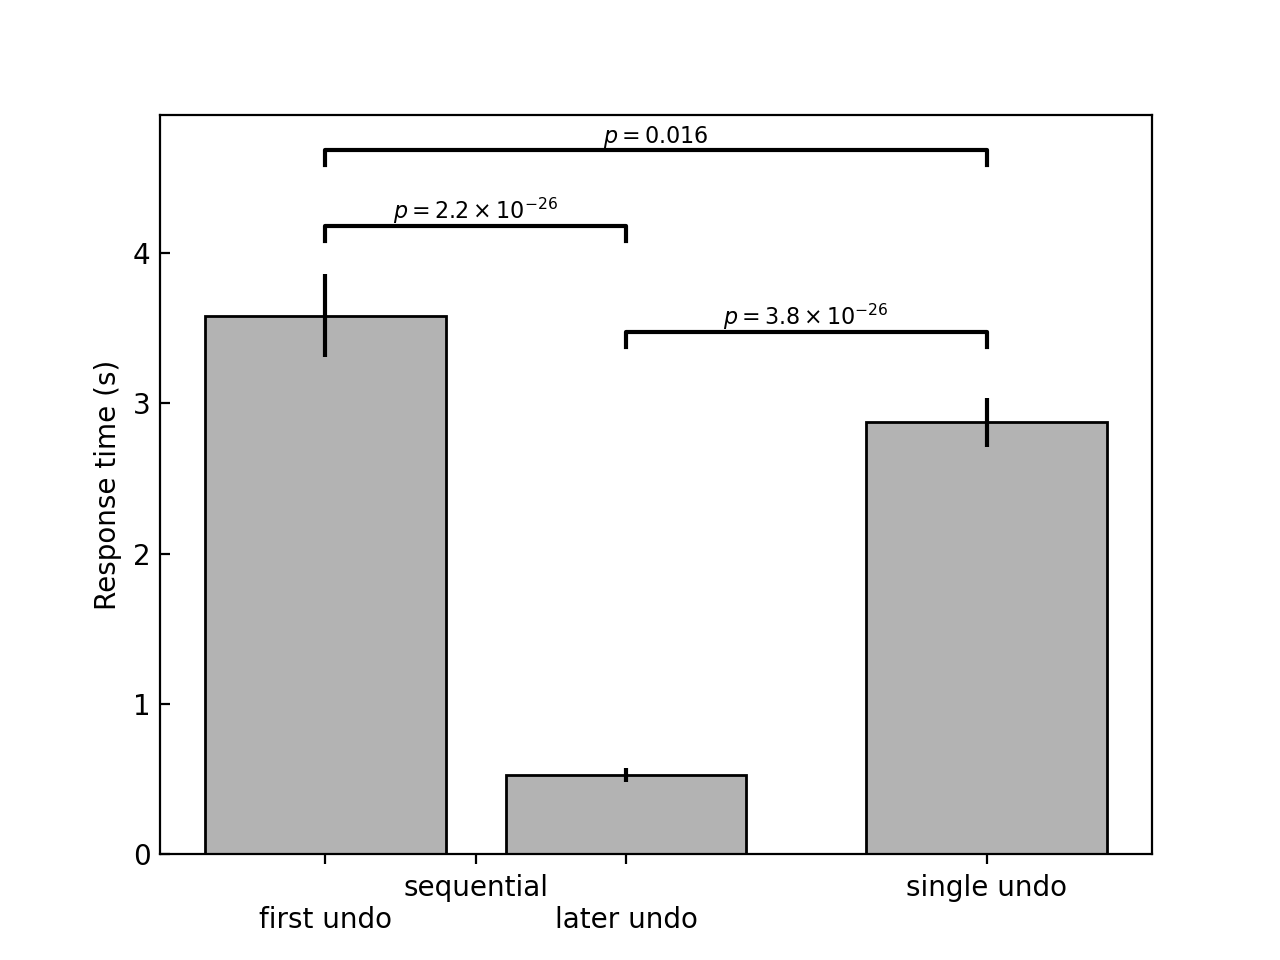

In [9]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)

bx = axs.bar([1,2,3.2],
             
             [
              np.nanmean(RT_firstUndo[0]),
              np.nanmean(RT_laterUndo[0]),
              np.nanmean(RT_singleUndo[0])],
             
             color = (.7,.7,.7), 
             
             edgecolor = 'k',
             
             yerr=[RT_firstUndo[1],
                  RT_laterUndo[1],
                  RT_singleUndo[1]])

axs.set_xticks([1,1.5,2,3.2])
axs.set_xticklabels(labels = ['\nfirst undo','sequential','\nlater undo','single undo'])#,fontsize=18
axs.set_facecolor('white')
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_color('k')
axs.tick_params(axis='y', colors='k', direction='in',left = True) #, labelsize = 16
axs.tick_params(axis='x', colors='k')
# axs.set_title('S'+str(i+1), fontsize = 16)
axs.set_ylabel('Response time (s)') #,fontsize=18

# fig.set_figwidth(26)
# fig.set_figheight(12)

plt.show()
# fig.savefig(out_dir + 'undo_RT.png', dpi=600, bbox_inches='tight')

2.4671411742949085
0.43311039353557107
1.4719614374970007


<IPython.core.display.Javascript object>


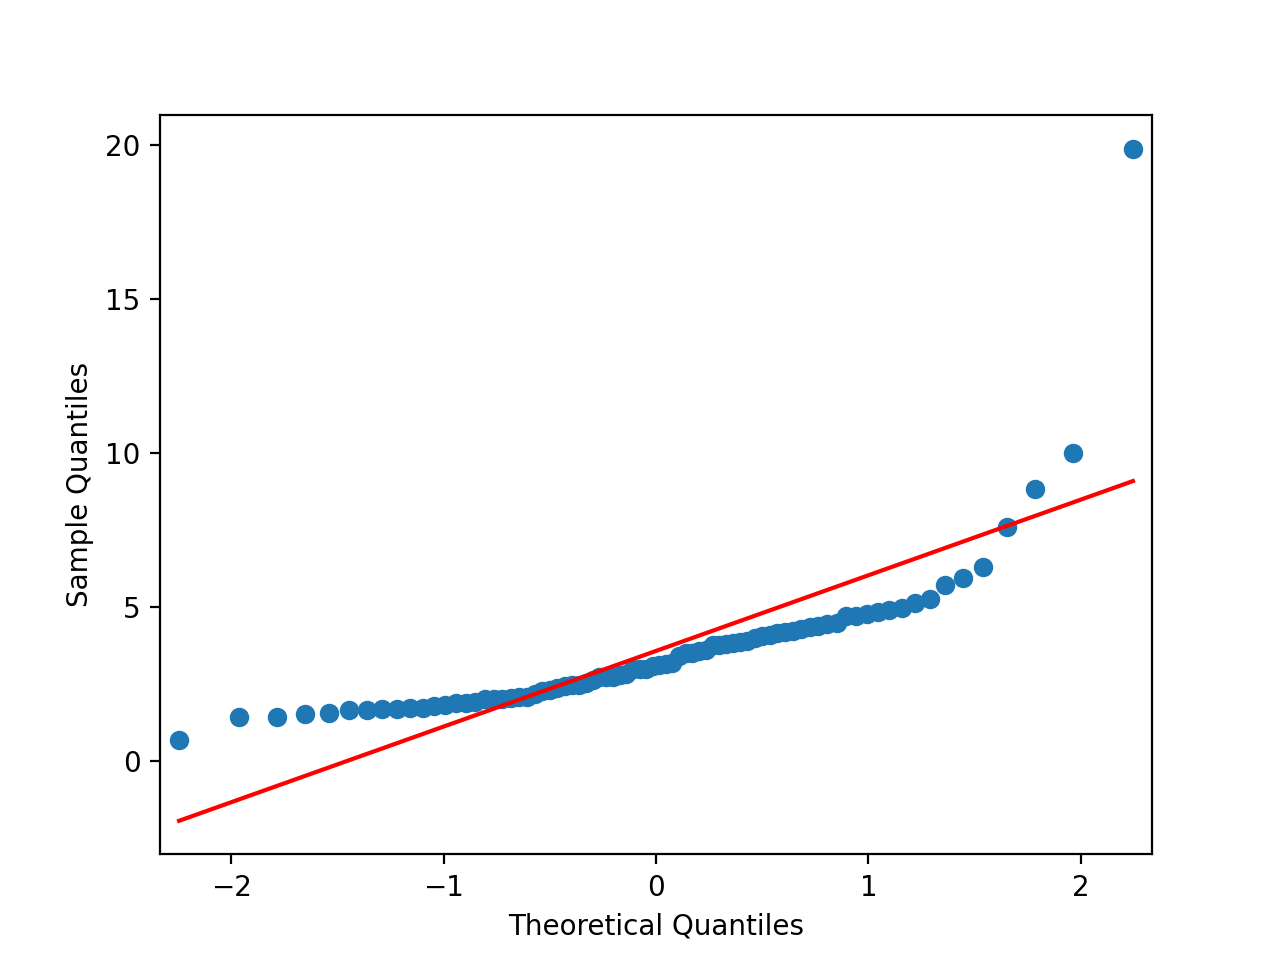

<IPython.core.display.Javascript object>


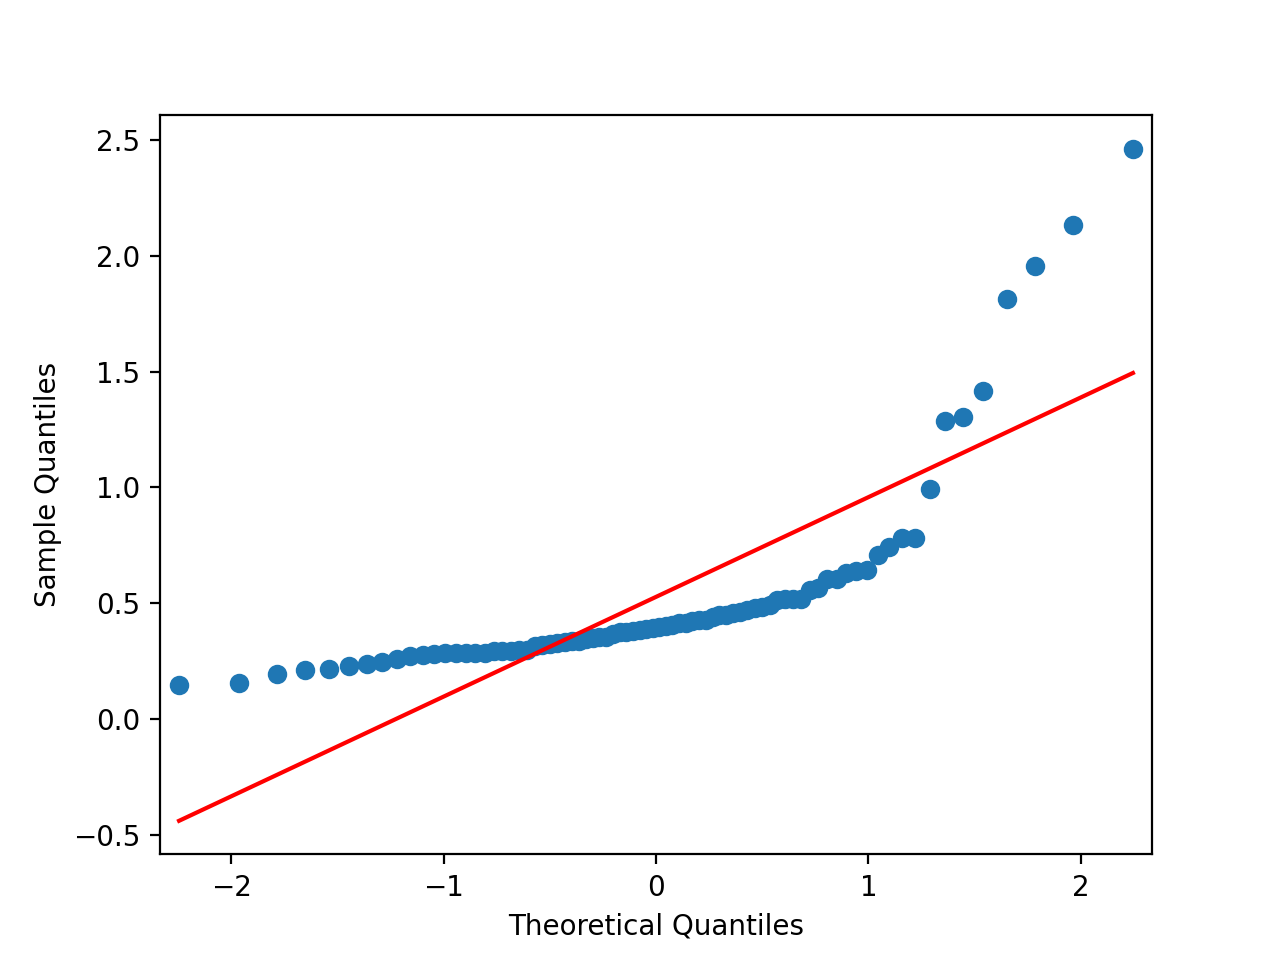

<IPython.core.display.Javascript object>


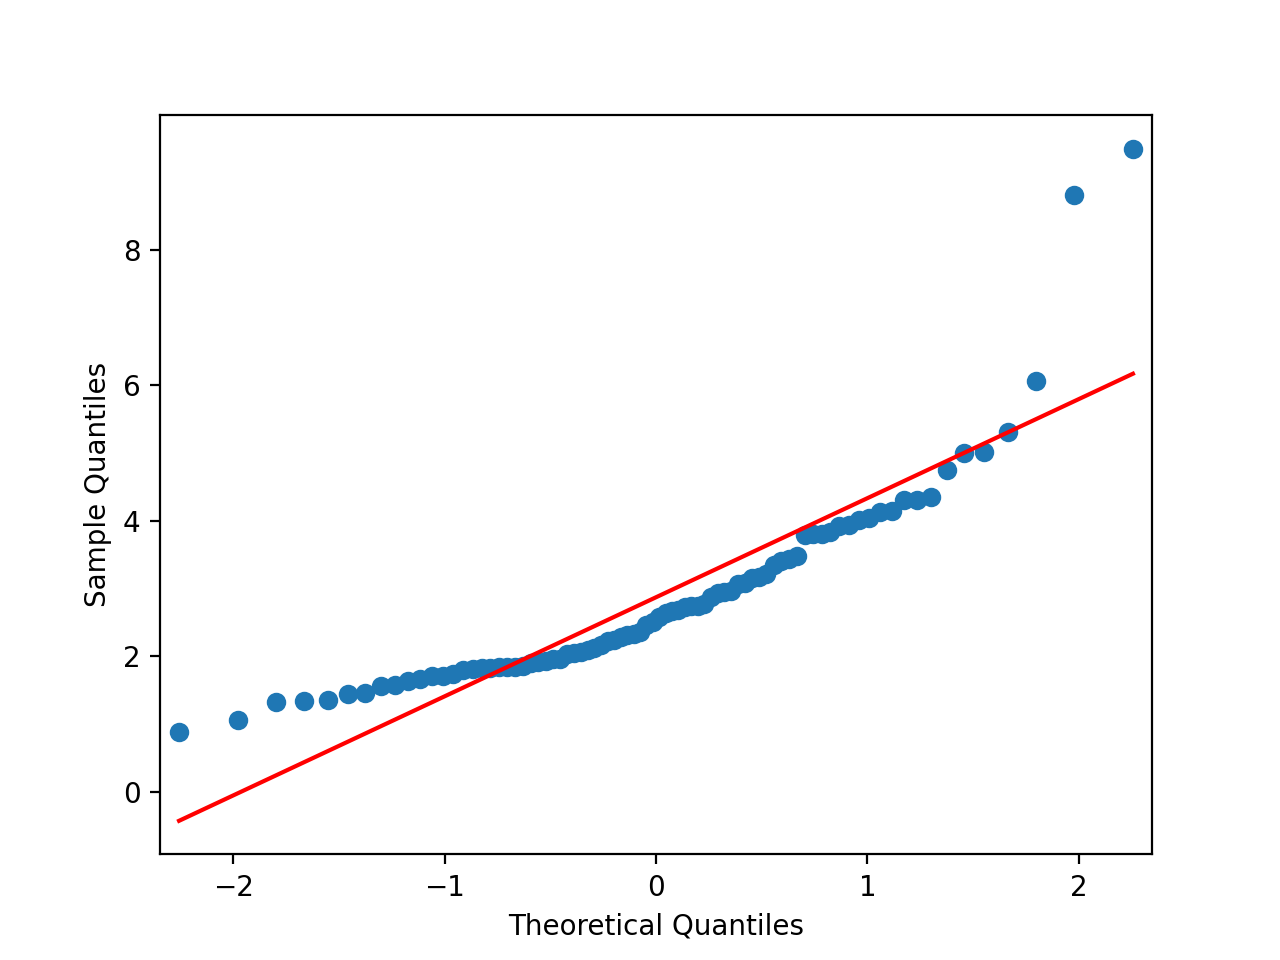

In [10]:
print(np.nanstd(RT_firstUndo[0], ddof=1))
print(np.nanstd(RT_laterUndo[0], ddof=1))
print(np.nanstd(RT_singleUndo[0], ddof=1))

# check normality ----
sm.qqplot(RT_firstUndo[0], line='s')
py.show()
sm.qqplot(RT_laterUndo[0], line='s')
py.show()
sm.qqplot(RT_singleUndo[0], line='s')
py.show()

In [11]:
#--------------------------------------
# run 2-independent-sample t test
stat1, p1 = mannwhitneyu(RT_firstUndo[0], RT_laterUndo[0])
x1, x2 = 1,2  
y, h, col = bx[0].get_height() + 0.5, 0.1, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)

#--------------------------------------
stat2, p2 = mannwhitneyu(RT_laterUndo[0],RT_singleUndo[0])

x1, x2 = 2,3.2 
y, h, col = bx[2].get_height() + 0.5, 0.1, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p2)

#--------------------------------------
stat3, p3 = mannwhitneyu(RT_firstUndo[0],RT_singleUndo[0])

x1, x2 = 1,3.2
y, h, col = bx[0].get_height() + 1, 0.1, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p3)

### box plot

<IPython.core.display.Javascript object>


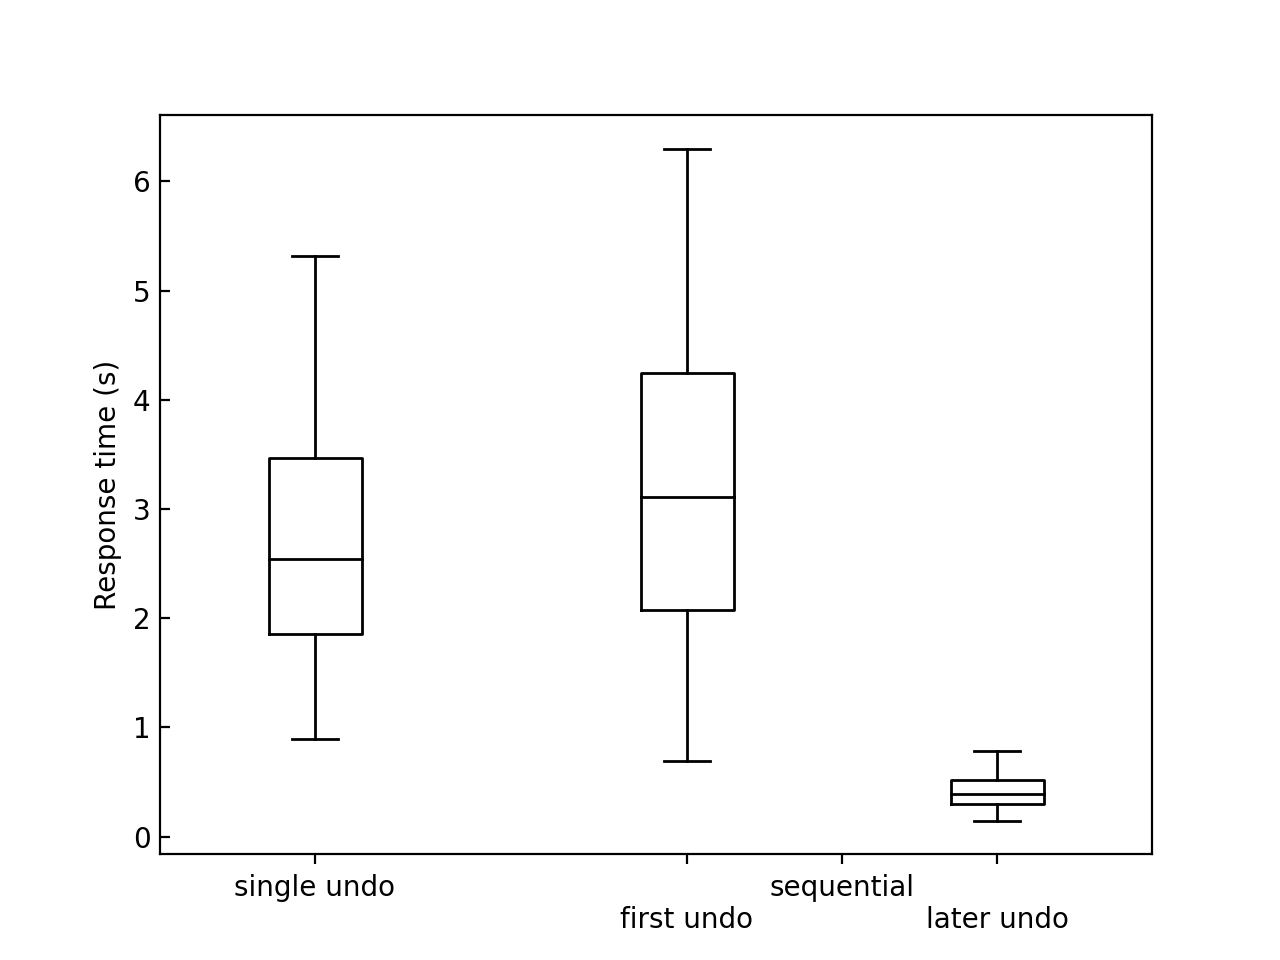

In [12]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)


bx = axs.boxplot(
    [
        RT_singleUndo[0],
        RT_firstUndo[0],
        RT_laterUndo[0]
    ],
    positions =[1,2.2,3.2],
    widths = 0.3,
    showfliers=False,
    whis = 1.5,
   medianprops = dict(color = 'k'))  #

axs.set_xticks([1,2.2,2.7,3.2])
axs.set_xticklabels(labels = ['single undo','\nfirst undo','sequential','\nlater undo'])#,fontsize=18
axs.set_facecolor('white')
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_color('k')
axs.tick_params(axis='y', colors='k', direction='in',left = True) #, labelsize = 16
axs.tick_params(axis='x', colors='k')
# axs.set_title('S'+str(i+1), fontsize = 16)
axs.set_ylabel('Response time (s)') #,fontsize=18

plt.show()
# fig.savefig(out_dir + 'undo_RT.png', dpi=600, bbox_inches='tight')

# § Terminal / Non-terminal

## proportion

In [127]:
singleundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo == 1)
end_singleundo = data_choice_level.loc[data_choice_level.loc[singleundo,:].index-1, ["checkEnd",'subjects','puzzleID','allMAS']]
end_singleundo = end_singleundo.loc[(end_singleundo.allMAS==8)|(end_singleundo.allMAS==9),:]
end_singleundo['singleUndo'] = 1
end_singleundo['sequentialUndo'] = 0

sequentialundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo != 1)&((data_choice_level.allMAS==8)|(data_choice_level.allMAS==9))
end_sequentialundo = data_choice_level.loc[data_choice_level.loc[sequentialundo,:].index-1,["checkEnd",'subjects','puzzleID','allMAS']]
end_sequentialundo = end_sequentialundo.loc[(end_sequentialundo.allMAS==8)|(end_sequentialundo.allMAS==9),:]
end_sequentialundo['singleUndo'] = 0
end_sequentialundo['sequentialUndo'] = 1

end_undo_df = pd.concat([end_singleundo,end_sequentialundo])

# end_singleundo_avg = end_singleundo.groupby(['subjects'])['checkEnd'].mean()
# end_sequentialundo_avg = end_sequentialundo.groupby(['subjects'])['checkEnd'].mean()

print(sum(end_undo_df.checkEnd==1))
print(sum(end_undo_df.checkEnd==0))
print(sum(end_undo_df.checkEnd==1)+sum(end_undo_df.checkEnd==0))

1506
428
1934


   checkEnd  sequentialUndo
0         0              78
1         1              81


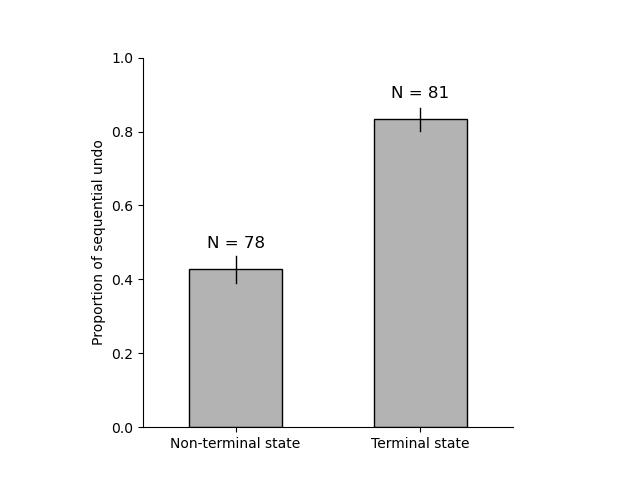

In [128]:
singleUndo_sub = end_undo_df.groupby(['subjects','checkEnd'])['sequentialUndo'].mean().reset_index()
#sequentialUndo_sub = error_undo_df.groupby(['subjects','severityOfErrors'])['sequentialUndo'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.barplot(x='checkEnd', y='sequentialUndo', 
            data = singleUndo_sub, 
            color= [0.7,0.7,0.7],
            edgecolor = ['k','k','k'],
            width=.5,
            linewidth=1,
            errcolor = 'k',
            errwidth = 1,
            errorbar = "se")

axs.set_xticklabels(labels = [ "Non-terminal state" , "Terminal state"])#,fontsize=18
n_sub = singleUndo_sub.groupby(['checkEnd'])['sequentialUndo'].count().reset_index()
# add text on the upper of each bar 
for x, y, n in zip([0,1], singleUndo_sub.groupby(['checkEnd'])['sequentialUndo'].mean(), n_sub.sequentialUndo):
    axs.text(x, y+0.05, "N = " + str(n), ha='center', va='bottom', fontsize=12)

  
axs.set_yticks(np.linspace(0,1,6))
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel = '', ylabel='Proportion of sequential undo')
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')

fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
#plt.show()

print(n_sub)

0.2886662282789768
0.29757374542404647


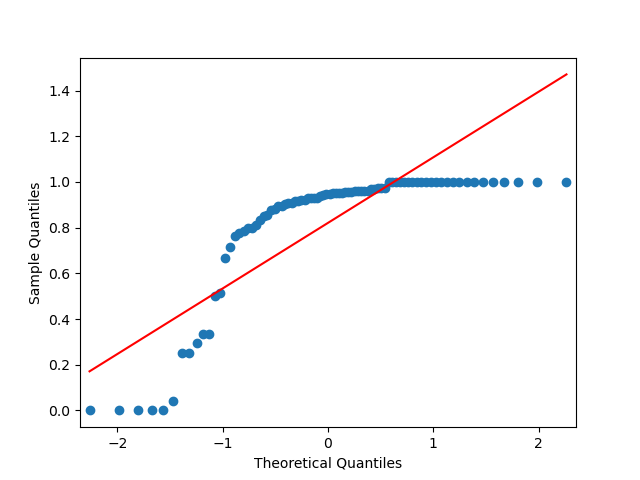

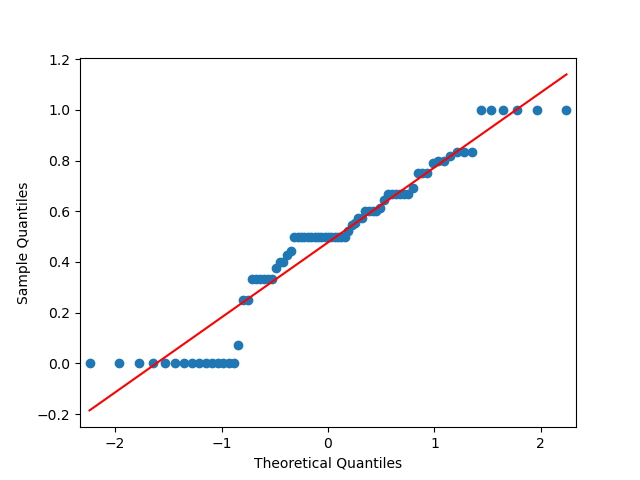

In [9]:
%matplotlib widget
# run 2-independent-sample t test
## check variance
print(np.std(singleUndo_sub.loc[(singleUndo_sub.checkEnd==1),'sequentialUndo'], ddof=1))
print(np.std(singleUndo_sub.loc[(singleUndo_sub.checkEnd==0),'sequentialUndo'], ddof=1))
## check normality
sm.qqplot(singleUndo_sub.loc[(singleUndo_sub.checkEnd==1),'sequentialUndo'], line='s')
py.show()
sm.qqplot(singleUndo_sub.loc[(singleUndo_sub.checkEnd==0),'sequentialUndo'], line='s')
py.show()

In [15]:
stat1, p1 = mannwhitneyu(np.array(singleUndo_sub.loc[(singleUndo_sub.checkEnd==1),'sequentialUndo']), 
                     np.array(singleUndo_sub.loc[(singleUndo_sub.checkEnd==0),'sequentialUndo'])) # should not be paired test! Because of unequal variance, and the measurements are rather unrelated
print(stat1)
print(p1)
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

5423.0
2.194581026983643e-12


Text(0.5, 1.0, '$p = 2.2\\times 10^{-12}$')

## GLMM

In [15]:
end_singleundo = data_choice_level.loc[data_choice_level.loc[singleundo,:].index-1, ["checkEnd", 'subjects','puzzleID']]
end_singleundo["undo_type"] = 0
end_sequentialundo = data_choice_level.loc[data_choice_level.loc[sequentialundo,:].index-1, ["checkEnd", 'subjects','puzzleID']]
end_sequentialundo["undo_type"] = 1
undotype_end_df = pd.concat([end_singleundo, end_sequentialundo])


In [66]:
%%R -i undotype_end_df

undotype_end_df$subject <- factor(undotype_end_df$subject)
undotype_end_df$undo_type <- factor(undotype_end_df$undo_type)
undotype_end_df$checkEnd <- factor(undotype_end_df$checkEnd)

model_undotype_end = glm(undo_type ~  1 + checkEnd + (1 |subjects),
                                  data = undotype_end_df, family = "binomial")

# get the coefficients for the best fitting model
summary(model_undotype_end)


Call:
glm(formula = undo_type ~ 1 + checkEnd + (1 | subjects), family = "binomial", 
    data = undotype_end_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9646   0.5601   0.5601   0.5601   1.1150  

Coefficients: (1 not defined because of singularities)
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)        0.1487     0.0843   1.764   0.0778 .  
checkEnd1          1.6243     0.1047  15.519   <2e-16 ***
1 | subjectsTRUE       NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2753.7  on 2659  degrees of freedom
Residual deviance: 2516.4  on 2658  degrees of freedom
AIC: 2520.4

Number of Fisher Scoring iterations: 4



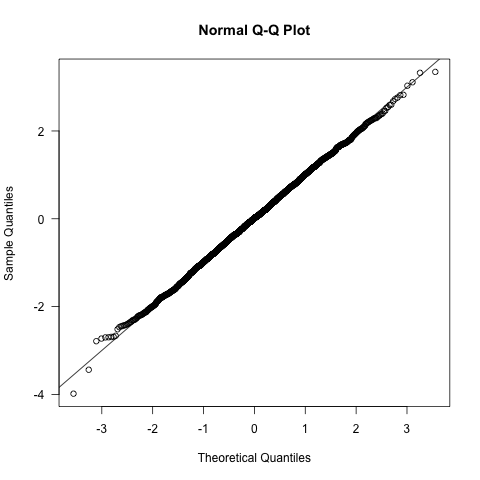

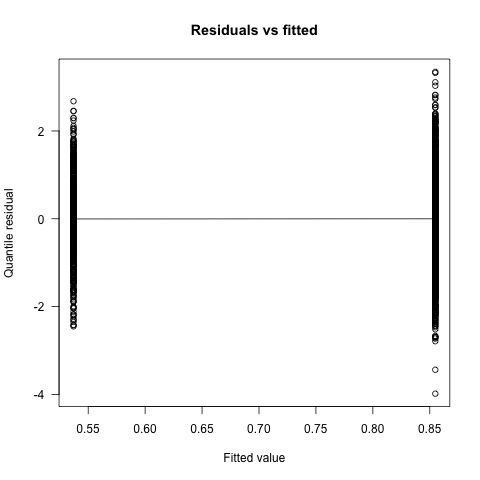

In [17]:
%%R
qres <- qresid(model_undotype_end); 
qqnorm(qres, las=1); 
abline(0, 1)

scatter.smooth( qres~fitted(model_undotype_end), las=1, main="Residuals vs fitted",
      xlab="Fitted value", ylab="Quantile residual")

#  severity of error of the last move

In [55]:
singleundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo == 1)
error_singleundo = data_choice_level.loc[data_choice_level.loc[singleundo,:].index-1, ["severityOfErrors",'subjects','puzzleID']]
error_singleundo['singleUndo'] = 1
error_singleundo['sequentialUndo'] = 0

sequentialundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo != 1)
error_sequentialundo = data_choice_level.loc[data_choice_level.loc[sequentialundo,:].index-1,["severityOfErrors",'subjects','puzzleID']]
error_sequentialundo['singleUndo'] = 0
error_sequentialundo['sequentialUndo'] = 1

error_undo_df = pd.concat([error_singleundo,error_sequentialundo])

error_singleundo_avg = error_singleundo.groupby(['subjects'])['severityOfErrors'].mean()
error_sequentialundo_avg = error_sequentialundo.groupby(['subjects'])['severityOfErrors'].mean()


These two types of plot are essentially equivalent (using the same data)

## Boxplot of error severity for each undo type

80

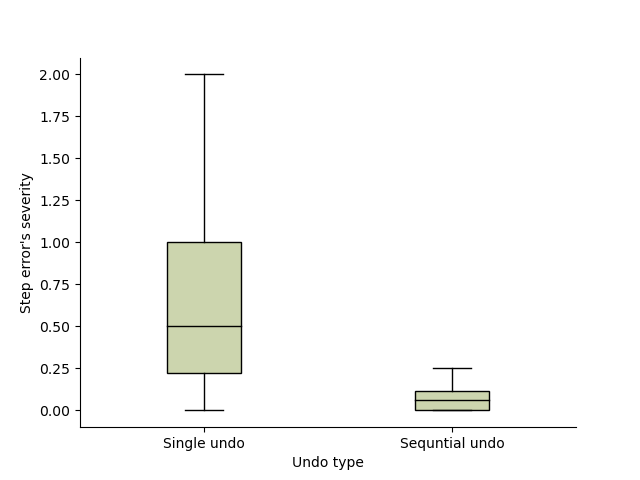

In [56]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)
# axs.bar([1,2,3,4],np.nanmean(dat_subjects,axis = 0),
#         color=['#ccd5ae','#ccd5ae','#fefae0','#fefae0'],
#         hatch=['//','','//',''],edgecolor = 'k', 
#         yerr=np.std(dat_subjects,axis = 0)/np.sqrt(dat_subjects.shape[0]))

bx = axs.boxplot(
    [np.array(error_singleundo_avg), np.array(error_sequentialundo_avg)],
    positions =[1,2],
    widths = 0.3,
    showfliers=False,
    patch_artist=True,
    whis = 1.5,
    medianprops = dict(color = 'k'))  #

colors = ['#ccd5ae','#ccd5ae']
for patch, color in zip(bx['boxes'], colors):
    patch.set_facecolor(color)

axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['Single undo',
                              'Sequntial undo'])#,fontsize=18

axs.set_ylabel("Step error\'s severity")
axs.set_xlabel('Undo type')

#plt.show()
# fig.savefig(out_dir + 'undo_prob_end_state.png', dpi=600, bbox_inches='tight')
len(error_singleundo_avg)
len(error_sequentialundo_avg)

0.4764236011358828
0.12704758042421727


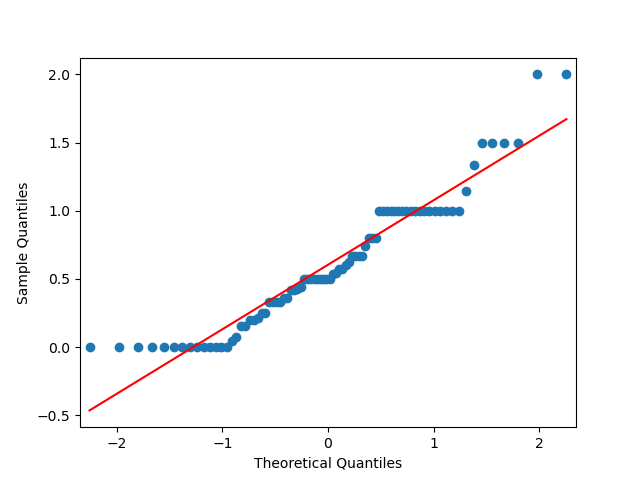

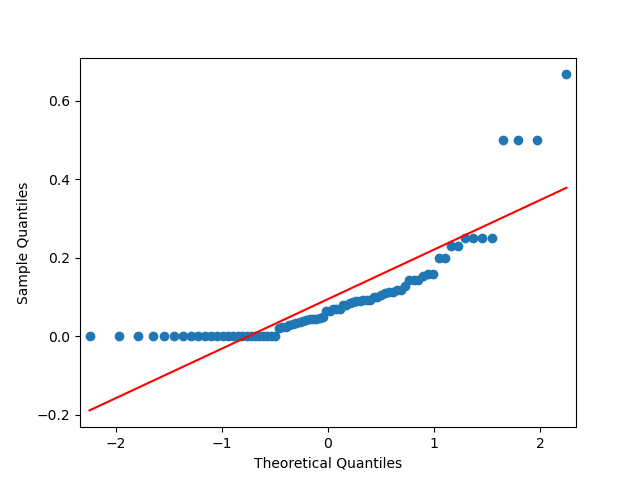

5390.5
1.038673049061689e-12


Text(0.5, 1.0, '$p = 1.0\\times 10^{-12}$')

In [9]:
# check equal variance ----
print(np.std(error_singleundo_avg, ddof=1))
print(np.std(error_sequentialundo_avg, ddof=1))
## violated

# check normality ----
sm.qqplot(error_singleundo_avg, line='s')
py.show()
sm.qqplot(error_sequentialundo_avg, line='s')
py.show()
## violated

stat1, p1 = mannwhitneyu(np.array(error_singleundo_avg), np.array(error_sequentialundo_avg))
print(stat1)
print(p1)
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

## § Proportion of undo type, given Error magnitude

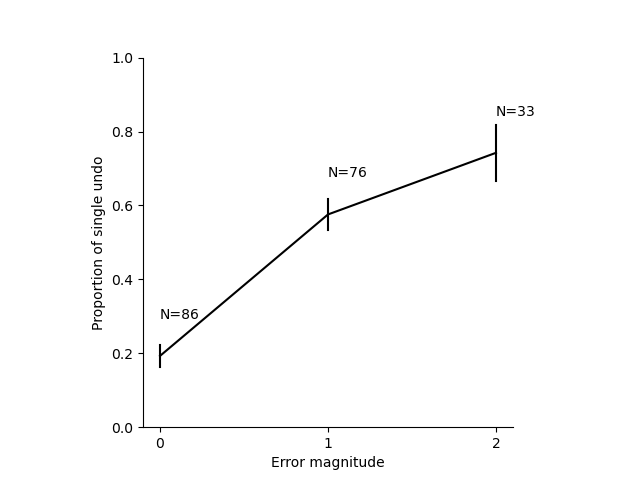

,severityOfErrors,subjects
0,0,86
1,1,76
2,2,33
3,3,14
4,4,1
5,6,1


In [107]:
singleUndo_sub = error_undo_df.groupby(['subjects','severityOfErrors'])['singleUndo'].mean().reset_index()
#sequentialUndo_sub = error_undo_df.groupby(['subjects','severityOfErrors'])['sequentialUndo'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
lineplot = sns.lineplot(x='severityOfErrors', y='singleUndo', 
             data = singleUndo_sub[singleUndo_sub.severityOfErrors<=2], 
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([0,1,2])
axs.set_yticks([0,0.2,0.4,0.6,0.8,1])

n_sub = singleUndo_sub[singleUndo_sub.severityOfErrors<=2].groupby(['severityOfErrors'])['subjects'].count().reset_index()
# add each n_sub to each dot on the line,  y uses the position of each dot
# loop through lineplot dots
for i in range(len(n_sub)):
    # add text to lineplot
    lineplot.text(x = n_sub.severityOfErrors[i], # x-coordinate position of data label, padded to be right of the scatterplot
                  y = singleUndo_sub[singleUndo_sub.severityOfErrors<=2].groupby(['severityOfErrors'])['singleUndo'].mean()[i]+0.1, # y-coordinate position of data label, padded to be above scatterplot
                  s = "N="+str(n_sub.subjects[i]), # data label, formatted to ignore decimals
                  color = 'black') # set colour of line


#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='Error magnitude', ylabel='Proportion of single undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
singleUndo_sub.groupby(['severityOfErrors'])['subjects'].count().reset_index()


In [108]:
# index before undo/not undo, but the possibility of undo cannot be 0
index_undo = sc_data_choice_level.index[(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_error = sc_data_choice_level.loc[index_undo+1, ["subjects","undo",'firstUndo','lastUndo']]
# add sc_data_choice_level.loc[index_undo, "severityOfErrors"] as a list column to undo_error
undo_error['severityOfErrors'] = sc_data_choice_level.loc[index_undo, "severityOfErrors"].values
undo_error['sequential_undo'] = (undo_error.firstUndo != undo_error.lastUndo)&(undo_error.firstUndo == 1)
undo_error['single_undo'] = (undo_error.firstUndo == undo_error.lastUndo)&(undo_error.firstUndo == 1)


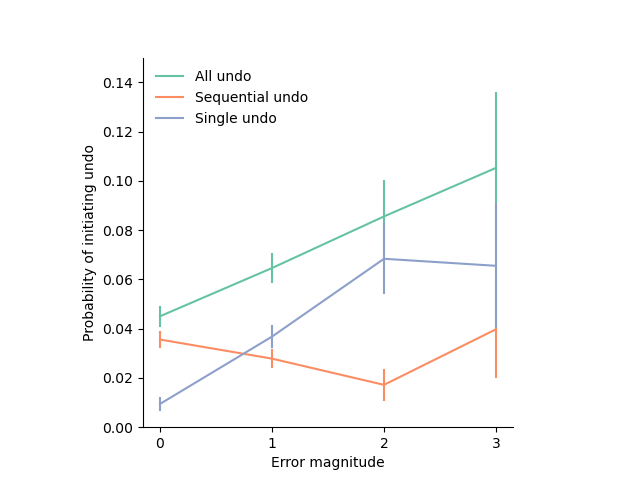

,severityOfErrors,subjects
0,0,100
1,1,100
2,2,98
3,3,65
4,4,22
5,5,3
6,6,3


In [133]:
allUndo_sub = undo_error.groupby(['subjects','severityOfErrors'])['undo'].mean().reset_index()
singleUndo_sub = undo_error.groupby(['subjects','severityOfErrors'])['single_undo'].mean().reset_index()
sequentialundo_sub = undo_error.groupby(['subjects','severityOfErrors'])['sequential_undo'].mean().reset_index()
#sequentialUndo_sub = error_undo_df.groupby(['subjects','severityOfErrors'])['sequentialUndo'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='severityOfErrors', y='undo', 
             data = allUndo_sub[allUndo_sub.severityOfErrors<=3], 
             color = '#66c2a5',
             err_style = "bars",
             errorbar = "se")
sns.lineplot(x='severityOfErrors', y='sequential_undo',
             data = sequentialundo_sub[sequentialundo_sub.severityOfErrors<=3],
             color = '#fc8d62',
             err_style = "bars",
             errorbar = "se")
sns.lineplot(x='severityOfErrors', y='single_undo',
                data = singleUndo_sub[singleUndo_sub.severityOfErrors<=3],
                color = '#8da0cb',
                err_style = "bars",
                errorbar = "se")

# add manual legend
plt.legend(labels=['All undo','Sequential undo','Single undo'], loc='upper left')

axs.set_xticks([0,1,2,3])
axs.set_ylim(0,0.15)


axs.set(xlabel='Error magnitude', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')

singleUndo_sub.groupby(['severityOfErrors'])['subjects'].count().reset_index()

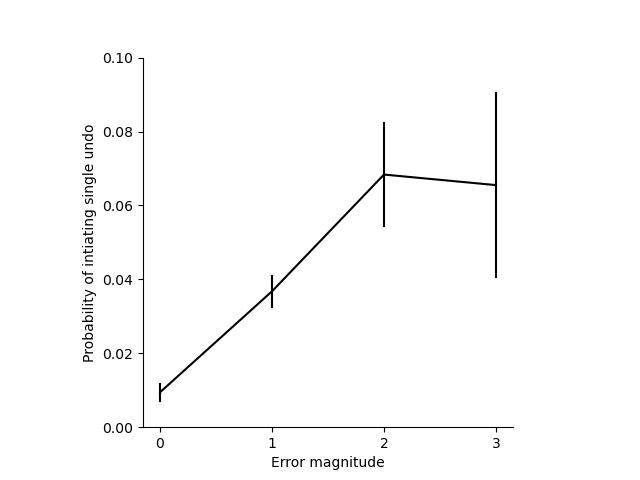

,severityOfErrors,subjects
0,0,100
1,1,100
2,2,98
3,3,65
4,4,22
5,5,3
6,6,3


In [118]:

#sequentialUndo_sub = error_undo_df.groupby(['subjects','severityOfErrors'])['sequentialUndo'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='severityOfErrors', y='single_undo', 
             data = singleUndo_sub[singleUndo_sub.severityOfErrors<=3], 
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([0,1,2,3])
axs.set_ylim(0,0.1)
#axs.set_yticks([0,0.2,0.4,0.6,0.8,1])
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='Error magnitude', ylabel='Probability of intiating single undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
singleUndo_sub.groupby(['severityOfErrors'])['subjects'].count().reset_index()

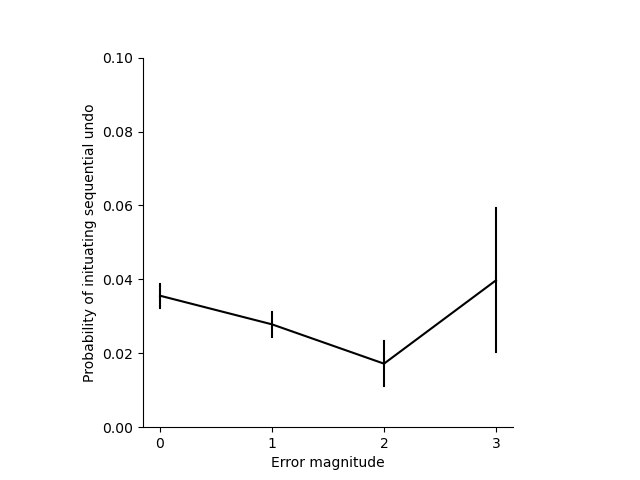

,severityOfErrors,sequential_undo
0,0,100
1,1,100
2,2,98
3,3,65
4,4,22
5,5,3
6,6,3


In [121]:
singleUndo_sub = undo_error.groupby(['subjects','severityOfErrors'])['sequential_undo'].mean().reset_index()
#sequentialUndo_sub = error_undo_df.groupby(['subjects','severityOfErrors'])['sequentialUndo'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='severityOfErrors', y='sequential_undo', 
             data = singleUndo_sub[singleUndo_sub.severityOfErrors<=3], 
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([0,1,2,3])
# set y-axis limit with step size 0.02
axs.set_ylim(0,0.1)

#axs.set_yticks([0,0.2,0.4,0.6,0.8,1])
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='Error magnitude', ylabel='Probability of inituating sequential undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
singleUndo_sub.groupby(['severityOfErrors'])['sequential_undo'].count().reset_index()

# undo RT and severity of error correlation

## all undos - undo RT and last move's severity of error correlation

### scatter plot

In [74]:
index_Undo = data_choice_level.index[(data_choice_level['firstUndo'] == 1)]
RT_df = data_choice_level.loc[index_Undo, ["log_undoRT","undoRT",'subjects','puzzleID']]
RT_df["severityOfErrors"] = np.array(data_choice_level.loc[index_Undo-1, "severityOfErrors"])

<IPython.core.display.Javascript object>


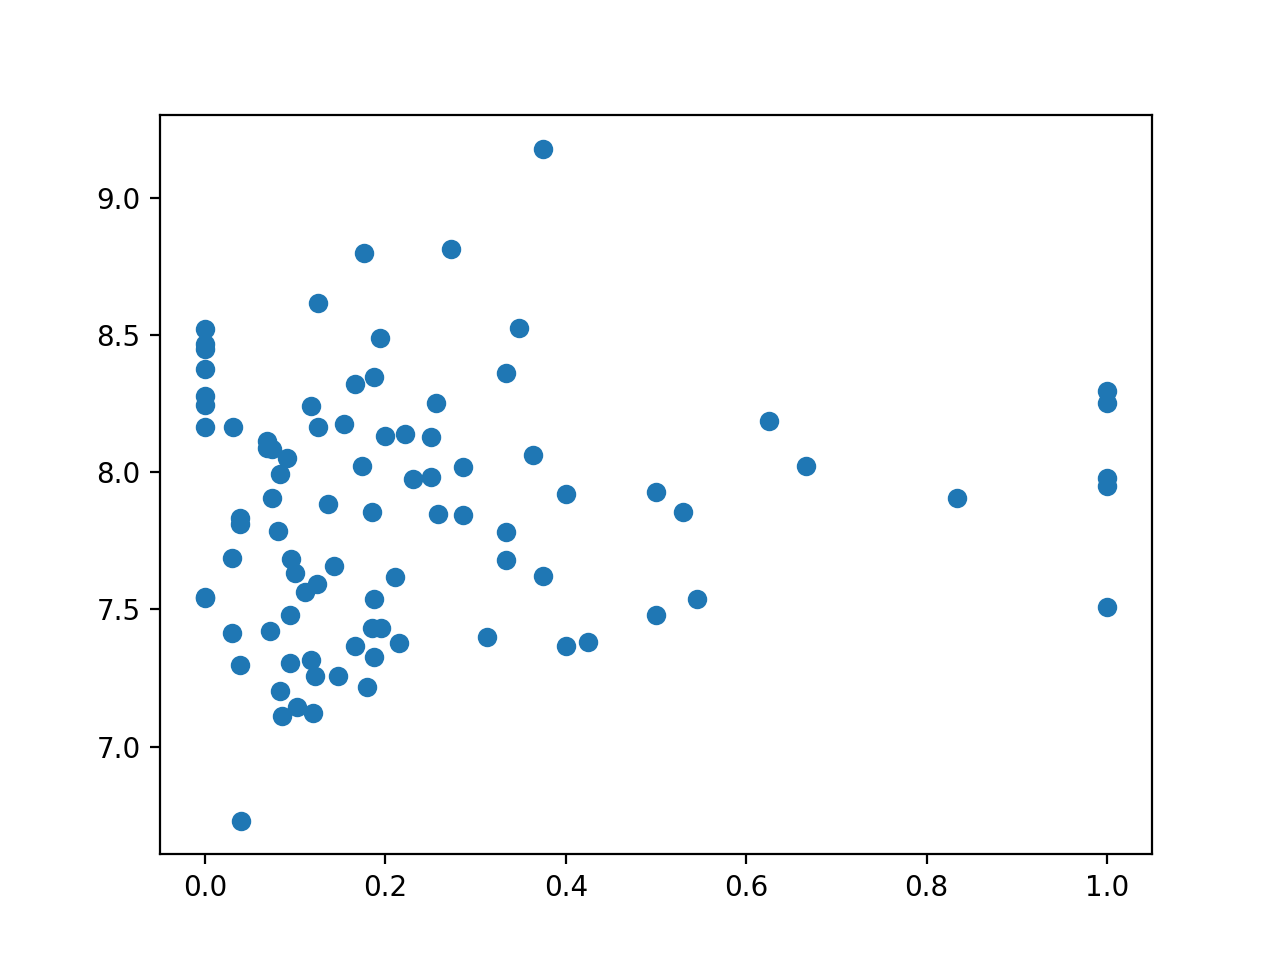

In [75]:
%matplotlib notebook
fig1, ax1 = plt.subplots()

plt.scatter(RT_df.groupby(['subjects'])['severityOfErrors'].mean(), RT_df.groupby(['subjects'])['log_undoRT'].mean())
plt.show()

In [76]:
corr, _ = spearmanr(RT_df.groupby(['subjects'])['severityOfErrors'].mean() , RT_df.groupby(['subjects'])['log_undoRT'].mean())
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: 0.059


<IPython.core.display.Javascript object>


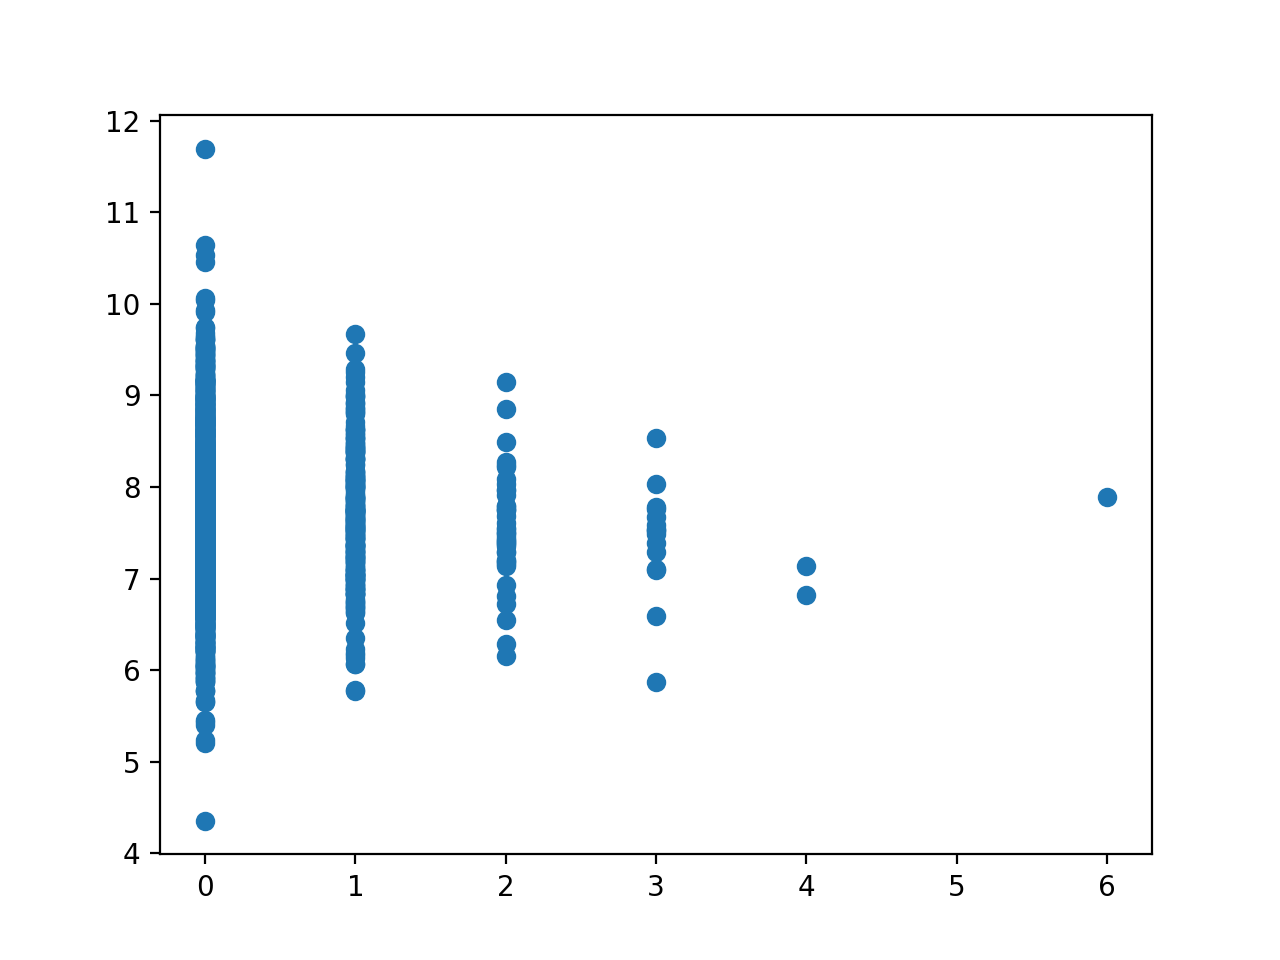

In [77]:
%matplotlib notebook
fig1, ax1 = plt.subplots()

plt.scatter(RT_df['severityOfErrors'], RT_df['log_undoRT'])
plt.show()

### GLMM

In [78]:
%%R -i RT_df

RT_df$subject <- factor(RT_df$subject)
RT_df$undoRT_lamda <- 1/sqrt(RT_df$undoRT)

model_undoRT_error = glm(undoRT_lamda ~  1 + severityOfErrors + (1 |subjects),
                                  data = RT_df, family = Gamma)

# get the coefficients for the best fitting model
summary(model_undoRT_error)


Call:
glm(formula = undoRT_lamda ~ 1 + severityOfErrors + (1 | subjects), 
    family = Gamma, data = RT_df)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.55970  -0.29501  -0.04556   0.18990   2.12413  

Coefficients: (1 not defined because of singularities)
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       42.6665     0.3327 128.249   <2e-16 ***
severityOfErrors  -0.2040     0.6651  -0.307    0.759    
1 | subjectsTRUE       NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.1456214)

    Null deviance: 374.15  on 2659  degrees of freedom
Residual deviance: 374.14  on 2658  degrees of freedom
AIC: -17939

Number of Fisher Scoring iterations: 5




Call:
glm(formula = undoRT_lamda ~ 1 + severityOfErrors + (1 | subjects), 
    family = inverse.gaussian(link = "identity"), data = RT_df)

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.179467  -0.019007  -0.000734   0.018448   0.111031  

Coefficients: (1 not defined because of singularities)
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       5.315373   0.007151 743.312   <2e-16 ***
severityOfErrors -0.012862   0.014329  -0.898    0.369    
1 | subjectsTRUE        NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for inverse.gaussian family taken to be 0.0008154449)

    Null deviance: 2.2028  on 2659  degrees of freedom
Residual deviance: 2.2021  on 2658  degrees of freedom
AIC: 1988.6

Number of Fisher Scoring iterations: 4



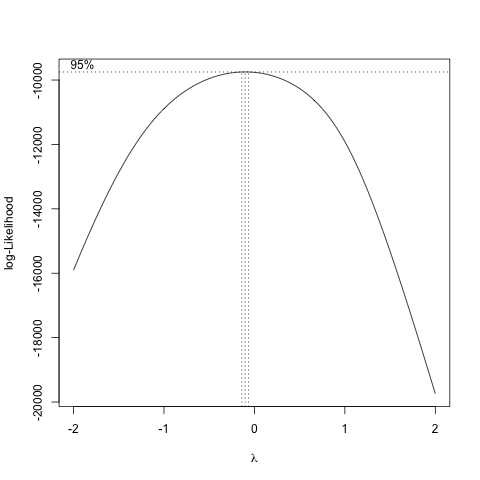

In [79]:
%%R
bc <- boxcox( undoRT ~  1 + severityOfErrors + (1 |subjects), lambda=seq(-2, 2, length=30), data=RT_df)
lambda <- bc$x[which.max(bc$y)]

RT_df$undoRT_lamda <- (RT_df$undoRT^lambda-1)/lambda

model_undoRT_error2 = glm(undoRT_lamda ~  1 + severityOfErrors + (1 |subjects),
                                  data = RT_df, family = inverse.gaussian(link="identity"))

# get the coefficients for the best fitting model
summary(model_undoRT_error2)

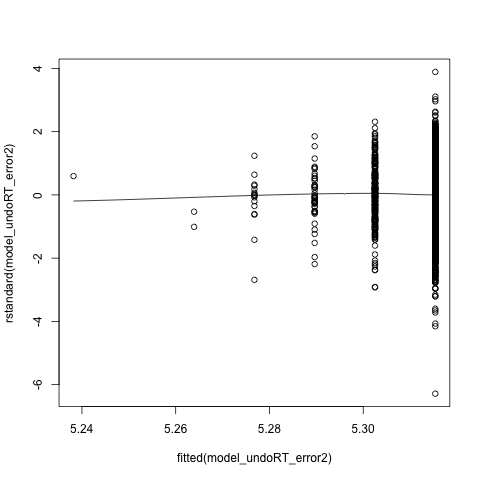

In [80]:
%%R

scatter.smooth(rstandard(model_undoRT_error2) ~ fitted(model_undoRT_error2))
# #qqnorm( qr1 <- qresid(model_undoRT_error), las=1 ); qqline( qr1 )
# rs <- cbind( rD=resid(model_undoRT_error), "r'D"=rstandard(model_undoRT_error),
#             "r''"=rstudent(model_undoRT_error), rQ=qresid(model_undoRT_error))
# apply( abs(rs), 2, max)

# cd.max <- which.max( cooks.distance(model_undoRT_error)) # Largest D
# cd.min <- which.min( cooks.distance(model_undoRT_error)) # Smallest D
# out <- cbind( DFFITS=dffits(model_undoRT_error), 
#              Cooks.distance=cooks.distance(model_undoRT_error),
#              Cov.ratio=covratio(model_undoRT_error))
# round( out[c(cd.min, cd.max),], 5)
#residuals(model_undotype_end)

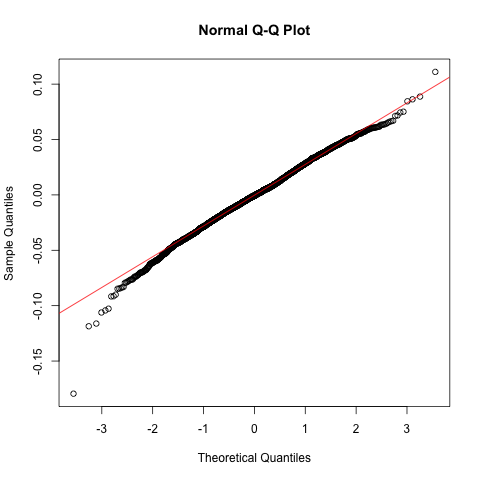

In [81]:
%%R
residual = resid(model_undoRT_error2)
qqnorm(residual)
qqline(residual, col = "red") 

## at the end - undo RT and last move's severity of error correlation

### scatter plot

In [99]:
end = (sc_data_choice_level.checkEnd == 1)&(sc_data_choice_level.submit != 1)
end_next_idx = sc_data_choice_level.loc[end,:].index + 1
end_next_df = sc_data_choice_level.loc[end_next_idx,]
is_undo = end_next_df[end_next_df["firstUndo"]==1]

RT_df = is_undo.loc[:,["log_undoRT","undoRT",'subjects','puzzleID']]
RT_df["severityOfErrors"] = np.array(data_choice_level.loc[is_undo.index-1, "severityOfErrors"])

<IPython.core.display.Javascript object>


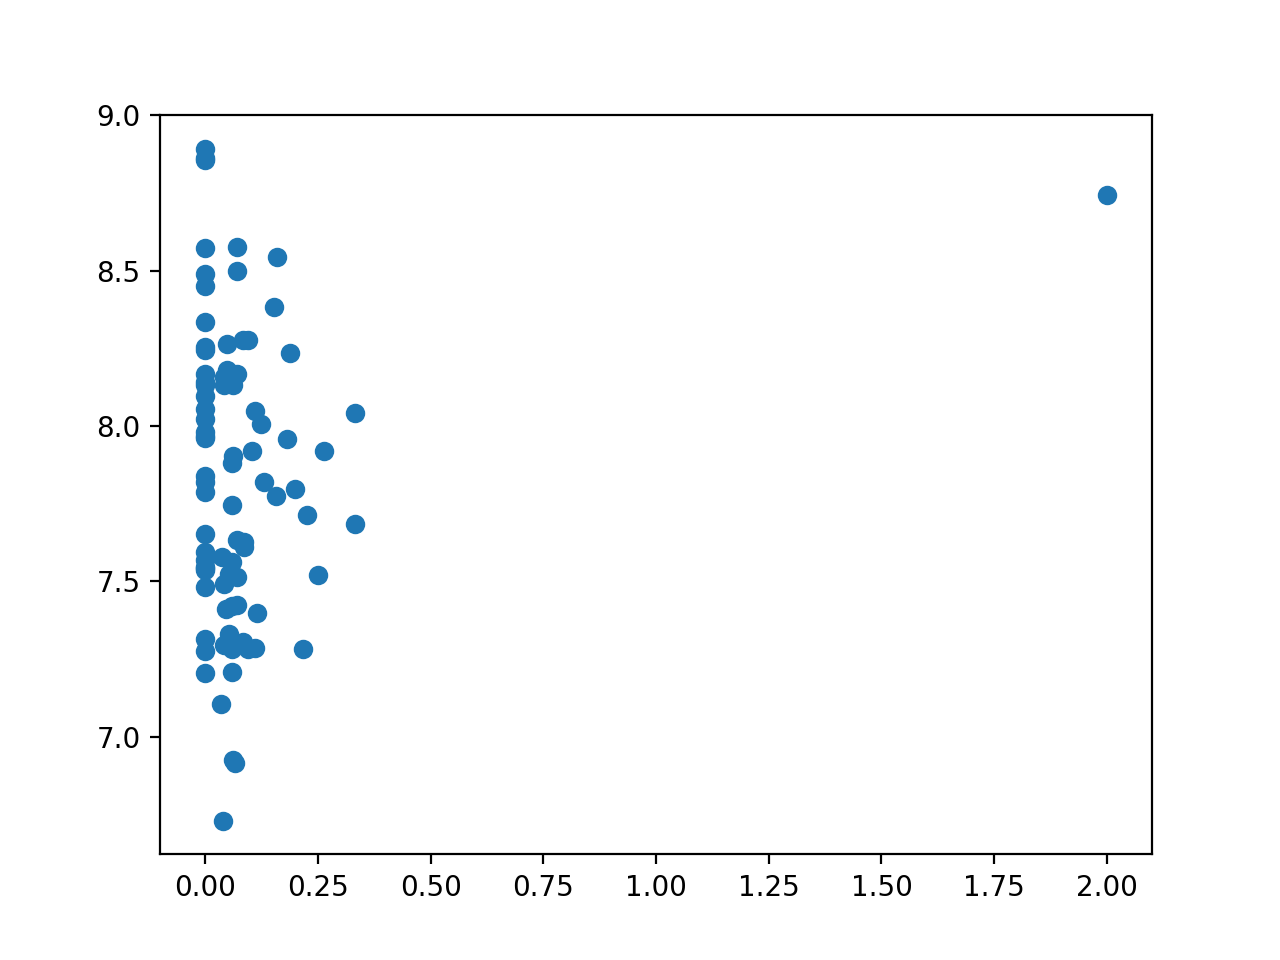

In [100]:
%matplotlib notebook
fig1, ax1 = plt.subplots()

plt.scatter(RT_df.groupby(['subjects'])['severityOfErrors'].mean(), RT_df.groupby(['subjects'])['log_undoRT'].mean())
plt.show()

In [101]:
corr, _ = spearmanr(RT_df.groupby(['subjects'])['severityOfErrors'].mean() , RT_df.groupby(['subjects'])['log_undoRT'].mean())
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.082


<IPython.core.display.Javascript object>


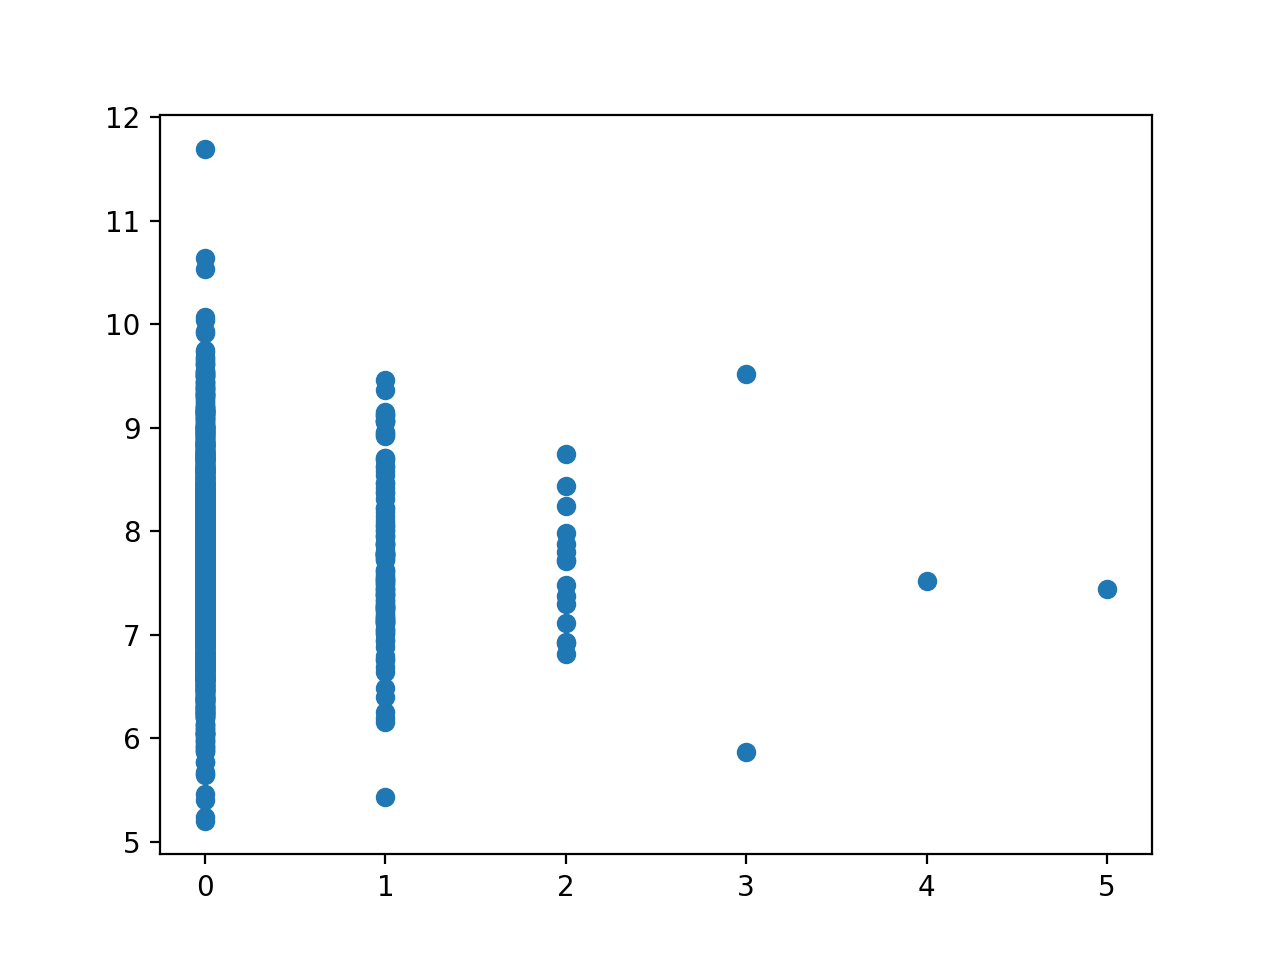

In [102]:
%matplotlib notebook
fig1, ax1 = plt.subplots()

plt.scatter(RT_df['severityOfErrors'], RT_df['log_undoRT'])
plt.show()

## at the end - undo RT and accumulated error correlation

### scatter plot

In [104]:
end = (sc_data_choice_level.checkEnd == 1)&(sc_data_choice_level.submit != 1)
end_next_idx = sc_data_choice_level.loc[end,:].index + 1
end_next_df = sc_data_choice_level.loc[end_next_idx,]
is_undo = end_next_df[end_next_df["firstUndo"]==1]

RT_df = is_undo.loc[:,["log_undoRT","undoRT",'subjects','puzzleID']]
RT_df["accumulated_error"] = np.array(data_choice_level.loc[is_undo.index-1, "allMAS"] - data_choice_level.loc[is_undo.index-1, "currNumCities"])


<IPython.core.display.Javascript object>


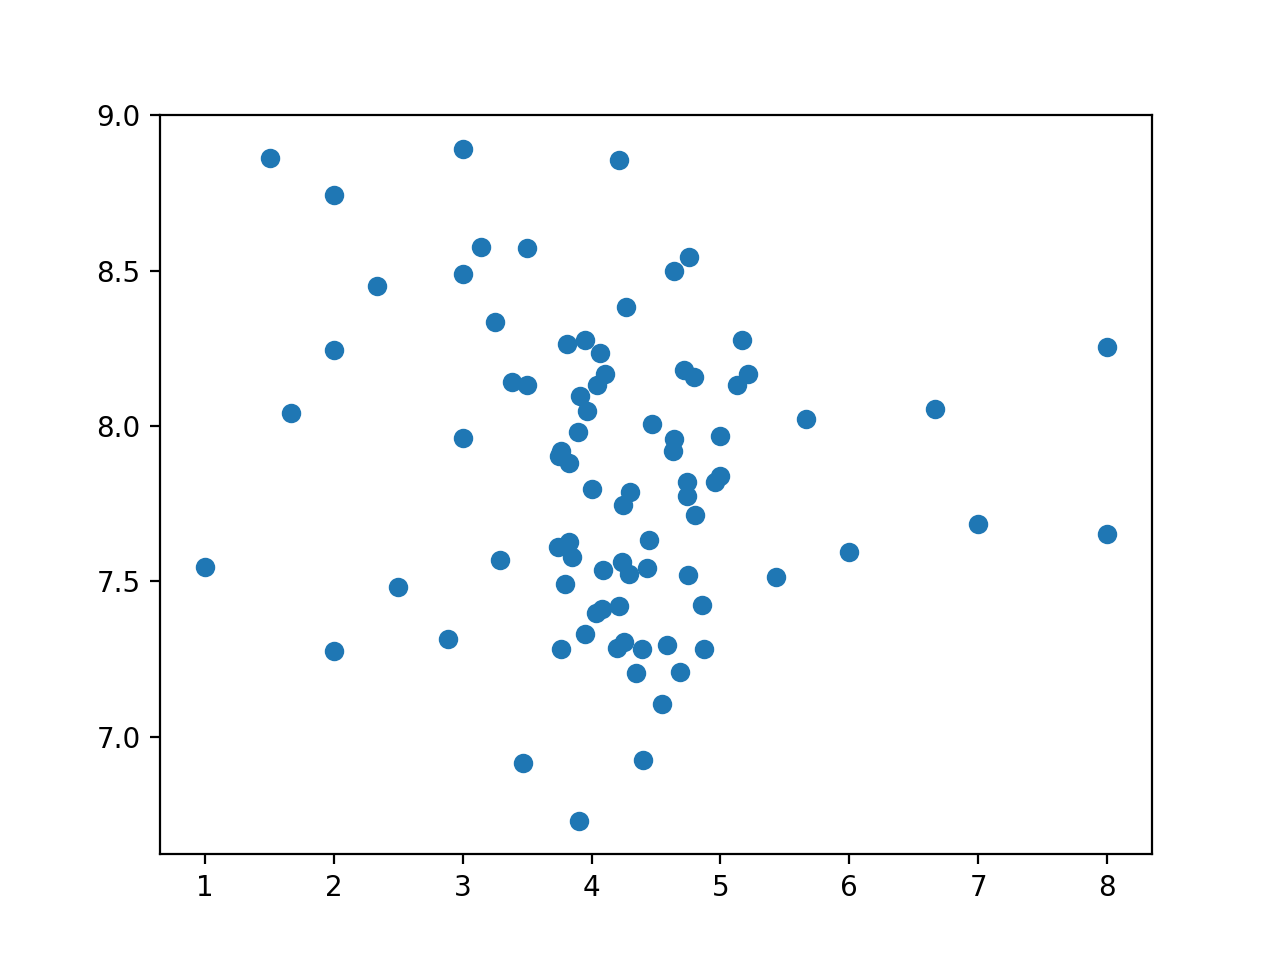

In [105]:
%matplotlib notebook
fig1, ax1 = plt.subplots()

plt.scatter(RT_df.groupby(['subjects'])['accumulated_error'].mean(), RT_df.groupby(['subjects'])['log_undoRT'].mean())
plt.show()

In [106]:
corr, _ = spearmanr(RT_df.groupby(['subjects'])['accumulated_error'].mean() , RT_df.groupby(['subjects'])['log_undoRT'].mean())
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.111


<IPython.core.display.Javascript object>


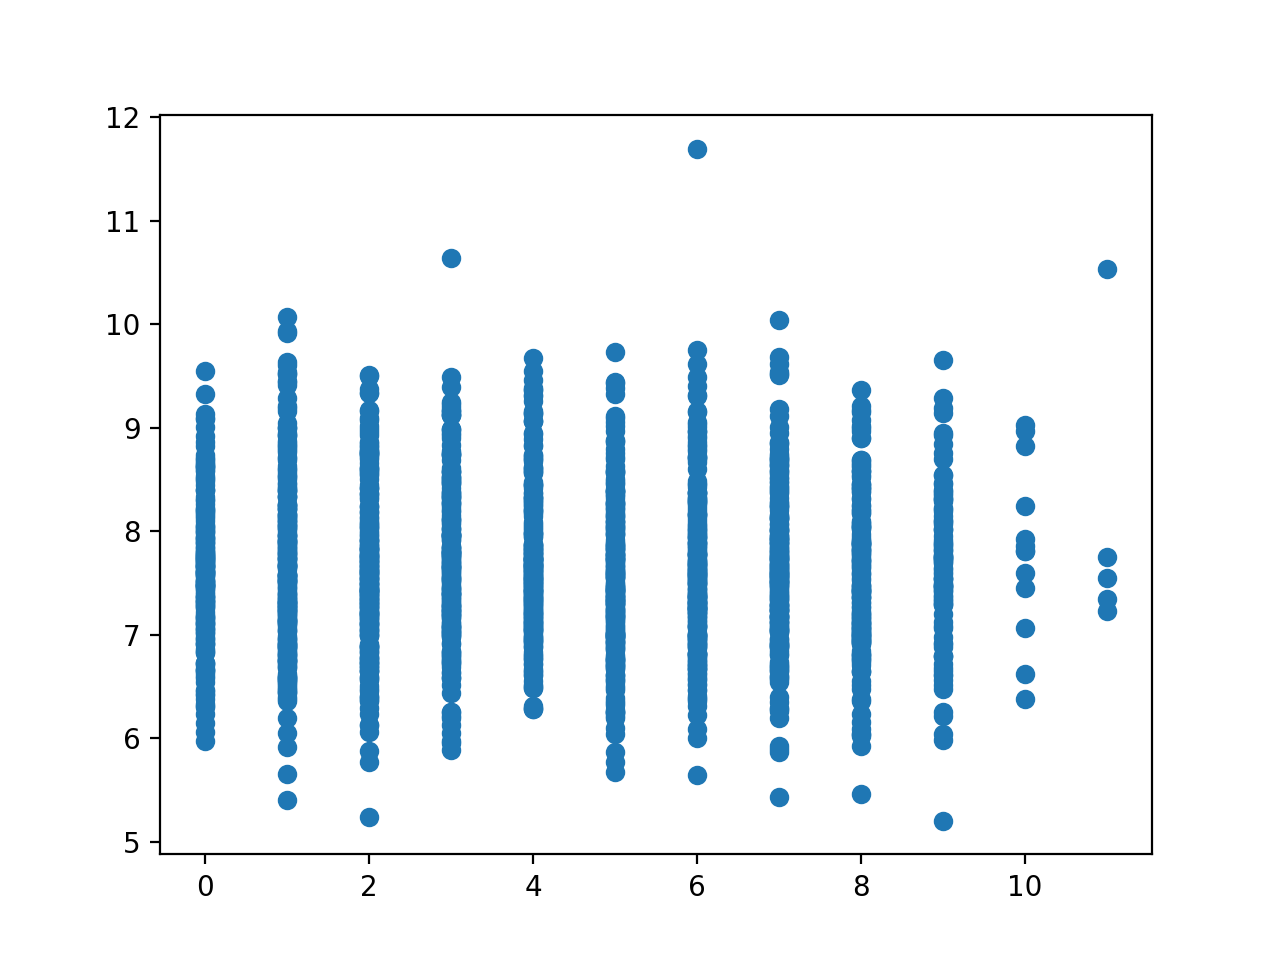

In [107]:
%matplotlib notebook
fig1, ax1 = plt.subplots()

plt.scatter(RT_df['accumulated_error'], RT_df['log_undoRT'])
plt.show()